# Project 4: Advanced Lane Lines
### By Steven Eisinger
---

## Pipeline description
1) read in image/video data

2) calibrate camera

3) threshold the image

4) change image perspective

5) find lanes

6) draw lanes onto original image

---

## Imports

In [2]:
# Udacity Self Driving Car Nanodegree Project 4
__title__ = 'SDC Project 4: Advanced Lane Lines'
__author__ = 'Steven Eisinger'

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## Find Chessboard Points
This is taken from the lesson example, but with a 9x6 chessboard instead of 8x6. One image wasn't scanned correctly (calibration1) because some of its edges fall off the bottom of the image.

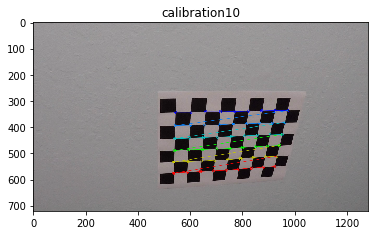

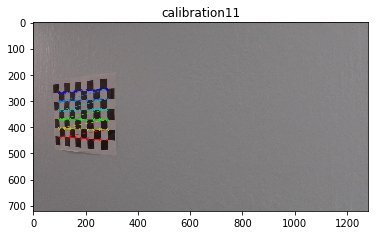

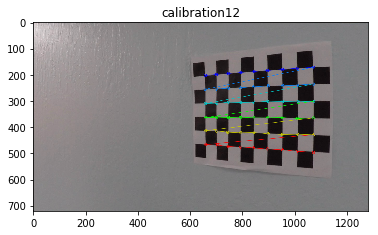

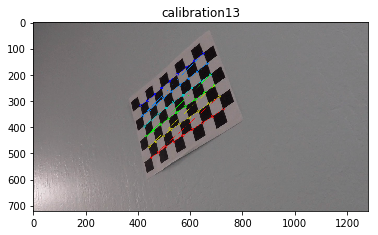

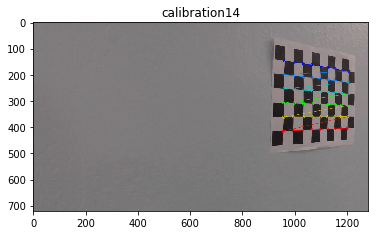

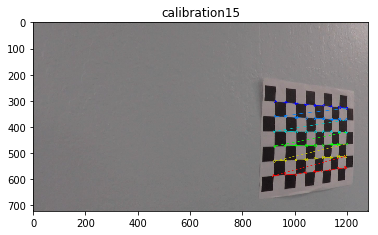

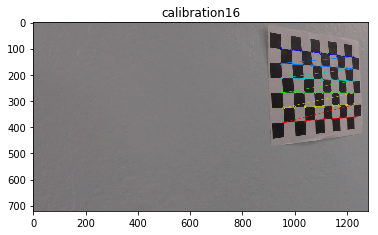

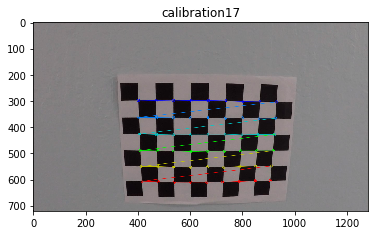

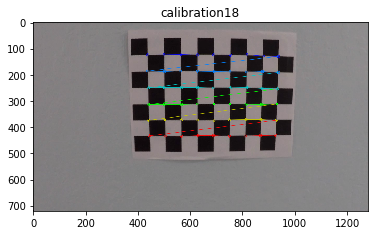

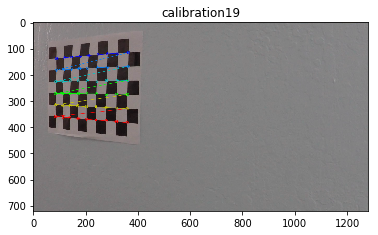

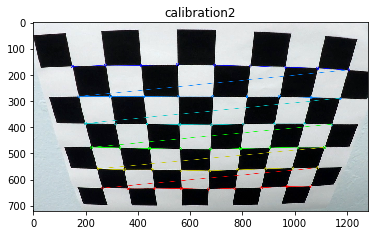

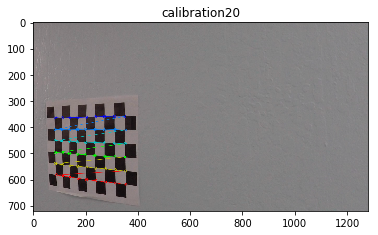

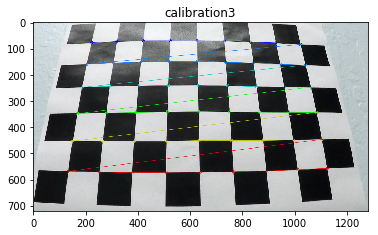

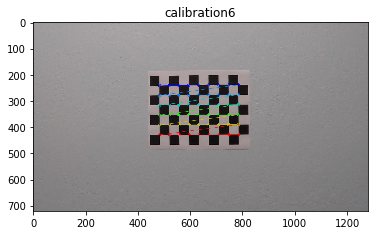

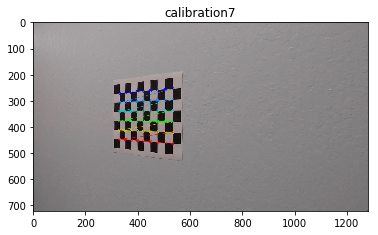

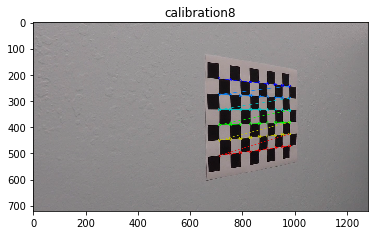

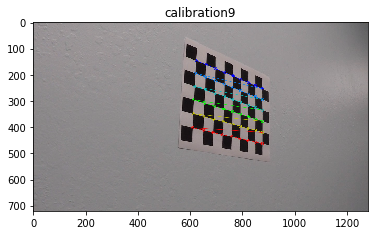

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
chess_y = 6
chess_x = 9
objp = np.zeros((chess_y*chess_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chess_x, 0:chess_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_x,chess_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chess_x,chess_y), corners, ret)
        write_name = 'output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        plt.imshow(img,cmap='gray')
        plt.title(fname.split('/')[-1].split('.')[0])
        plt.show()

## Camera Calibration and Distortion Correction
This is also taken from the lesson. Care must be taken to make sure the x and y dimentions are in the correct order, otherwise strange distortions effects can be seen in the 'undistorted' output.

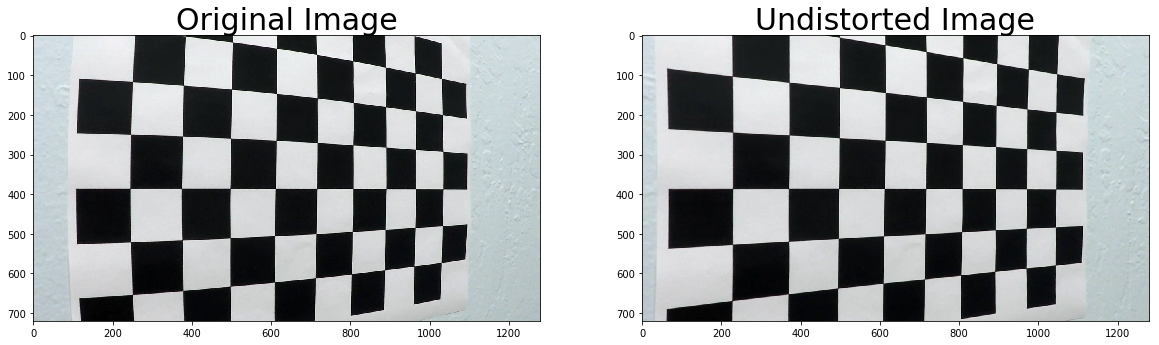

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist_calibration5.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Distortion Corrected Image
This is an example of camera calibration working on a road image

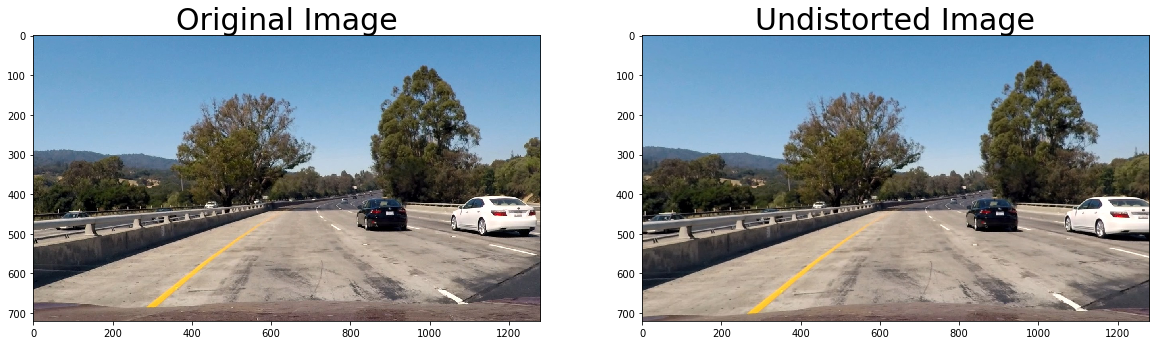

In [5]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist_test1.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Color and Gradient Threshold
Mostly copied from the lesson. This works by using the sobel x filter to find lines with a large vertical gradient component and also converts the image to the HLS color space to threshold the image by its saturation. Both of these techniques are combined to clean up the image for finding lanes, especially when shadows and irregular coloration on the road are present.

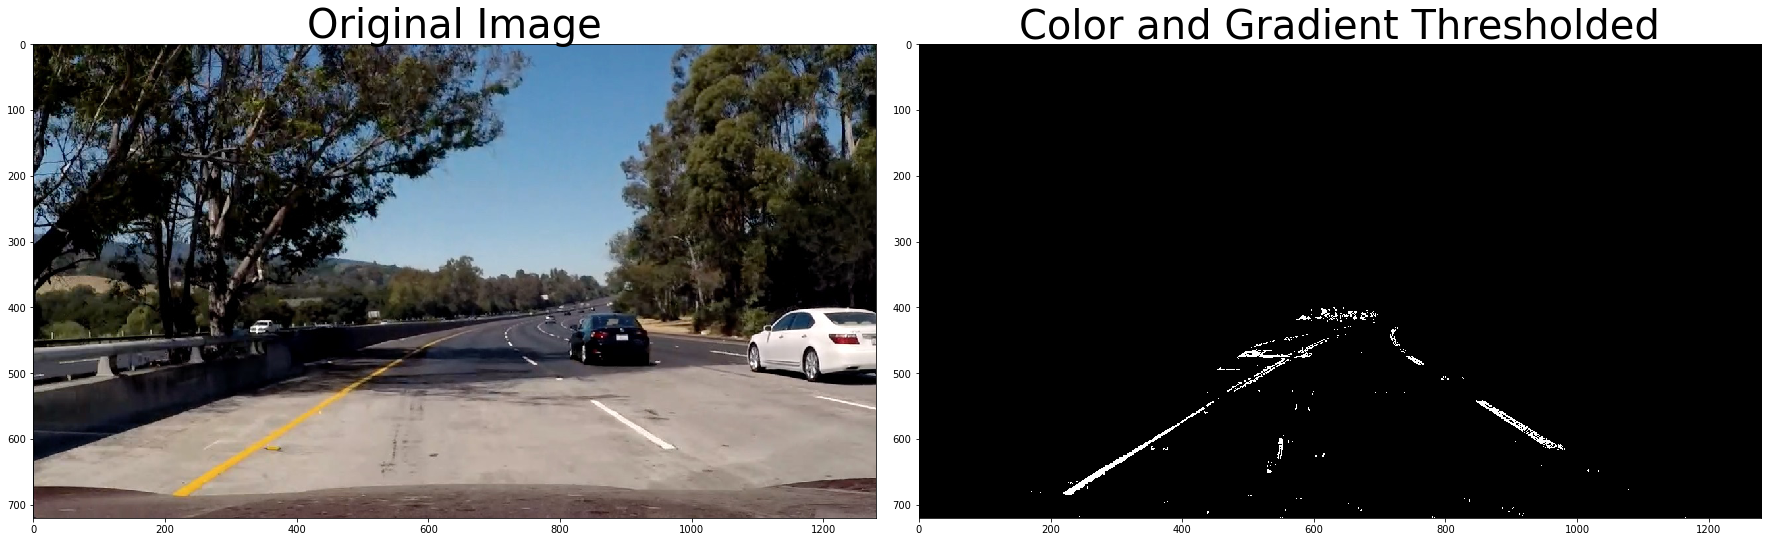

In [42]:
# Region of interest code from project 1
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Thresholding pipeline
def thresh_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Make image binary (Remove to see colors)
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    top_margin = 600
    bottom_margin = 100
    height = 400
    roi_vertices = np.array([[(bottom_margin,combined_binary.shape[0]),
                              (top_margin, height),
                              (combined_binary.shape[1]-top_margin, height),
                              (combined_binary.shape[1]-bottom_margin,combined_binary.shape[0])]],
                              dtype=np.int32)
    
    # Mask image to a region of interest
    output = region_of_interest(combined_binary, roi_vertices)
    
    return output

img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = thresh_pipeline(img, s_thresh=(195, 255), sx_thresh=(20, 100)) # TODO: Experiment with different values
cv2.imwrite('output_images/color_grad_thresh.jpg',result*255)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Color and Gradient Thresholded', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform
This section show how a bird's-eye view of the road can be optained using warpPerspective(). The src points were chosen by manually inspecting the images with the straight lines, iterating on the numbers until they appeared straight, then tring it with curved lines.

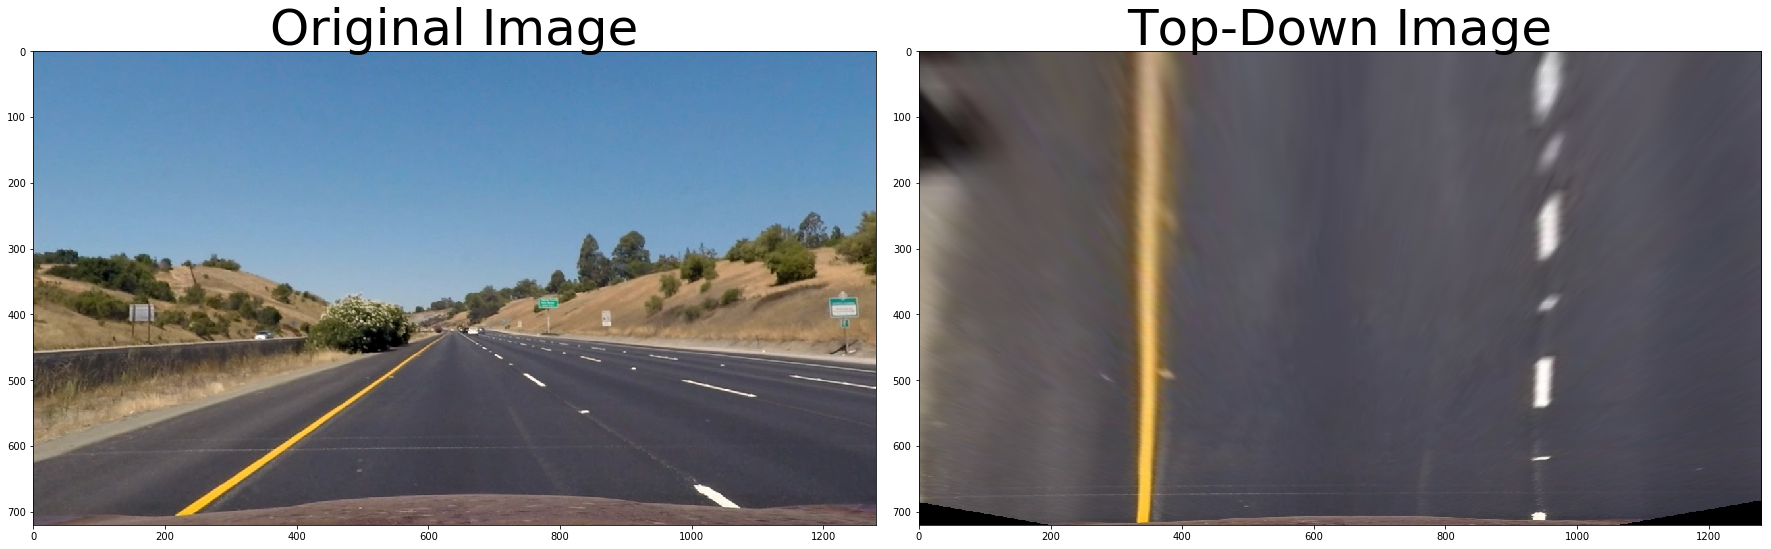

In [28]:
def top_down_perspective(img, M):
    # Use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
            
    return warped

dist_pickle = pickle.load( open( "camera_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

# Define src and dst based on straight line images
src = np.float32([(177, 720), (1132, 720), (593, 449), (683, 449)])
dst = np.float32([(320, 720), (960, 720), (320, 0), (960, 0)])
# Use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Save the M, Minv result for later use
M_pickle = {}
M_pickle["M"] = M
M_pickle["Minv"] = Minv
pickle.dump( M_pickle, open( "M_pickle.p", "wb" ) )

top_down = top_down_perspective(img, M)

cv2.imwrite('output_images/perspective_transform.jpg', cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Top-Down Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Lanes and Fit Polynomial
This is the sliding window with histogram method of finding lane lines from the lesson. windows slide from the center point of the image to find an area that contains above a certain number of pixels, then identifies this as the lane. This has to be done with a binary thresholded and warped images which we obtain using the techniques from the precious slides. Once window scanning completes, the non-zero lane pixels are separated and placed into either the left or right lane array. polyfit() is used to calculate a second order polynomial which fits through the points. This polynomial is then used to draw the area of the lane (the green part in the output image).

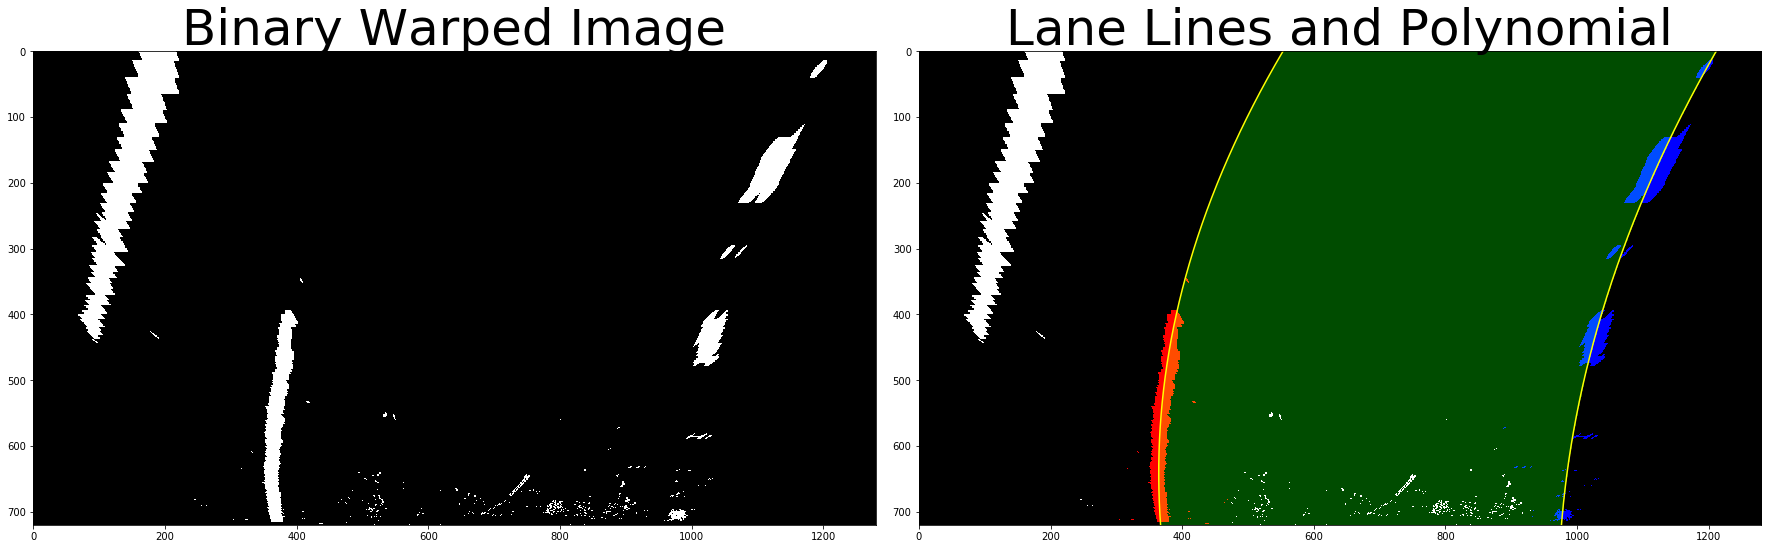

In [29]:
def find_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 60
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Draw lane
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line_pts, right_line_pts))
        
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, ploty, left_fitx, right_fitx

# Load image and undistort
dist_pickle = pickle.load( open( "camera_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('test_images/test1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
thresh = thresh_pipeline(img)
top_down = top_down_perspective(thresh, M)

out_img, ploty, left_fit, right_fit = find_lanes(top_down)

cv2.imwrite('output_images/find_lane_lines.jpg', out_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down, cmap='gray')
ax1.set_title('Binary Warped Image', fontsize=50)
ax2.imshow(out_img)
ax2.plot(left_fit, ploty, color='yellow')
ax2.plot(right_fit, ploty, color='yellow')
ax2.set_title('Lane Lines and Polynomial', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Radius of Curvature
The radius of curvature if copied from the lesson. It implements a known formula for finding the radius of curvature involvingthe derivatives of the line of best fit fount in the previous section. The pixels are converted to real distances to find the curvature in meters. The distance from center is calculated based on the bottom row of pixels. The center of the image and the lane is found, then their difference is calculated. Distance from center assumes the xm_per_pix scale is correct near the window and that the car camera is directly in the center of the vehicle.

In [30]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('Radius of curvature (px):', left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius of curvature (m):', left_curverad, 'm', right_curverad, 'm')

# Distance from center
lane_width_px = (right_fit[-1] - left_fit[-1])
meter_conversion = 3.7/lane_width_px
lane_center_px = left_fit[-1] + lane_width_px/2
car_center_px = out_img.shape[1]/2
dist_from_center = (lane_center_px-car_center_px)*meter_conversion # Positive: car left of center, Negative: car right of center
print('Distance from center of lane (m): ', dist_from_center)

Radius of curvature (px): 4.55966231763e+14 2.18599794318e+15
Radius of curvature (m): 357.382879995 m 480.043987036 m
Distance from center of lane (m):  0.192827552766


## Full Lane Finding Pipeline (Checkpoint)
This is the full implementation of the lane finding pipeline. I added a line to remove all white pixels from find_lanes() so the output is cleaner. top_down_perspective() is used at the end with the inverse transformation matrix to undistort the distorted lane image and superimpose it onto the original image.

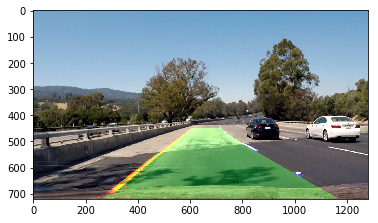

In [43]:
def draw_lanes(img, mtx, dist, M, Minv):
    # Calibrate camera
    calibrated = cv2.undistort(img, mtx, dist, None, mtx)
    # Threshold image
    thresholded = thresh_pipeline(calibrated, s_thresh=(195, 255), sx_thresh=(20, 100)) # TODO: Adjust thresholds
    # Get top-down perspective
    warped = top_down_perspective(thresholded, M)
    # Find lane lines
    lanes, ploty, left_fit, right_fit = find_lanes(warped)
    # Remove white pixels
    lanes[np.where((lanes == [255,255,255]).all(axis = 2))] = [0,0,0]
    # Unwarp image
    unwarped = top_down_perspective(lanes, Minv)
    
    img = cv2.addWeighted(img, 1, unwarped, 1, 0)
    return img

dist_pickle = pickle.load(open("camera_cal_pickle.p", "rb"))
M_pickle = pickle.load(open("M_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = M_pickle["M"]
Minv = M_pickle["Minv"]
img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
output = draw_lanes(img, mtx, dist, M, Minv)
cv2.imwrite('output_images/full_pipeline.jpg', cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
plt.imshow(output)

## Video Pipeline
The pipline is applied to the video, as done in project 1.

In [ ]:
from moviepy.editor import VideoFileClip

def process_image(img):
    return draw_lanes(img, mtx, dist, M, Minv)
    
movie_output = 'draw_lanes.mp4'
clip = VideoFileClip("project_video.mp4")
lane_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(movie_output, audio=False)

[MoviePy] >>>> Building video draw_lanes.mp4
[MoviePy] Writing video draw_lanes.mp4


 82%|████████▏ | 1037/1261 [17:35<1:46:03, 28.41s/it]  

In [ ]:
from moviepy.editor import ipython_display
ipython_display(movie_output, width=640)